# Cart on a track - simple linear form

Author: Sorin Moldoveanu<br>
Affiliation: home<br>
Status: under development<br>

__Introduction__

We will try to find out the minimum (cosntant) force applied to a cart moving free on a track. In other words, use as little force as possible.<br>
Example: we want to move the cart 100m in 10s. The initial velocity $v$ is 0, the final velocity is free. The mass of the cart $m$ is constant. The only control is the force $f$ applied, namely the acceleration $a$.

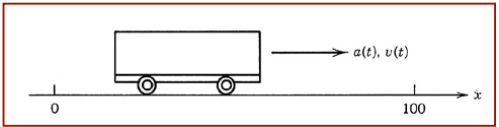

In order to describe what happens, equations are:<br>

$\dot{x} = v$<br>
$\dot{v}= f/m = a$<br>

Notations:<br>
$x=x_{1}$<br>
$v=x_{2}$<br>
$a = u = k = f/m$<br>

The function to minimize:<br>
$J=q(x_{1f}-100)^{2}+r\int_{0}^{t_{f}}a^{2}dt$<br>

Working a little on $J$, considering $a=const$, the function comes to:<br>
$J=q(50k-100)^{2}+10rk^{2}$<br>

In order to solve on a quantum computer, we put the function in a binary form, with a binary decision variable $x \in \left \{ 0,1 \right \}^n$ which indicate which control value to pick:<br>
$J=q(50x^{T}K-100)^{2}+10rx^{T}K^{2}$<br>

subject to restriction to pick one control value only:<br>
$x^{T}K=1$<br>

In the end, the objective is:<br>
$min \left ( q(50x^{T}K-100)^{2}+10rx^{T}K^{2}+p(1-x^{T}K)^{2} \right )$<br>

where $K$ is a vector of possible control(acceleration) values (for this case considering a sigle time interval) and $q,r,p$ are penalty terms (chose in such way in order to satisfy each objective)<br>

The objective is mapped to an Issing Hamiltonian whose groundstate corresponds to the optimal solution. This is done using the following assignment:<br>
$x \rightarrow (1-Z_{i})/2$  where $Z_{i}$ is the Pauli __Z__ operator that has eigenvalues = $\pm$1<br>

The module for value and Pauli operator calculus is cargo.py.<br>
We will implement the VQE quantum algorithm.<br>
NOTE: the results are not as expected; so, still work to do on this problem<br>

References

[1] Nielsen M. and Chuang I. "Quantum Computation and Quantum Information", Cambridge University Press (2010)<br>
[2] Qiskit open-source framework (qiskit, qiskit-aqua, qiskit-aer, qiskit-terra) at https://qiskit.org/ and https://github.com/Qiskit<br>
[3] IBMQ at https://quantumexperience.ng.bluemix.net<br>
[4] Patrik J. Coles et al, "Quantum Algorithm Implementation for Beginners", arXiv:1804.03719 (Apr 2018)<br>
[5] Lucas Andrew, "Ising formulations of many NP problems", arXiv"1302.5843 (Jan 2014)<br>
[6] Egger J. Daniel et al, "Qunatum optimization using variational algorithms on near-term quantum devices", arXiv:1710.01022 (Oct 2017)<br>
[7] Edward Fahri et al, "A quantum approximate optimization algorithm", arXiv:1411.4028 (Nov 2014)<br>
[9] Robert F. Stengel, "Optimal Control and Estimation", Courier Corportion (1994)<br>


In [1]:
#IMPORT
from qiskit import BasicAer
from qiskit_aqua import QuantumInstance
from qiskit_aqua import Operator, run_algorithm
from qiskit_aqua.input import EnergyInput
from qiskit_aqua.translators.ising import cart
from qiskit_aqua.algorithms import VQE, QAOA, ExactEigensolver
from qiskit_aqua.components.optimizers import COBYLA
from qiskit_aqua.components.variational_forms import RY
import numpy as np

#set for real device
#device = 'ibmq_16_melbourne'
from qiskit import IBMQ
IBMQ.load_accounts()
#backend = IBMQ.get_backend(device)

# define the problem
# variables
# n - number of acceleration elements to be taken into account
# K - acceleration vector; vector n x 1
# q - penalty
# p - penalty
# r - penalty

n = 5
q = 100
r = 1
p = 10
K=np.array([1.5,1.7,2,2.1,2.4])
e=np.ones(n)
E = np.matmul(np.asmatrix(e).T, np.asmatrix(e))

qubitOp, offset = cart.get_cart_qubitops(K, q, r, p)
algo_input = EnergyInput(qubitOp)
#print(offset, qubitOp)

#prepare some printing format
def index_to_selection(i, n):
    s = "{0:b}".format(i).rjust(n)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(n))])
    return x

def print_result(result):
    selection = cart.sample_most_likely(result['eigvecs'][0])
    #print('selection',selection)
    value = cart.cart_value(selection, K, q, r, p)
    print('\nvalue:',value)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))
    #print(selection,value)

    probabilities = np.abs(result['eigvecs'][0])**2
    i_sorted = reversed(np.argsort(probabilities))
    #i_sorted = reversed(np.argsort(value))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, n)
        #print('\nx=',x)
        value = cart.cart_value(x, K, q, r, p)    
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))
        #if value>=0: print('%10s\t%.4f\t\t%.4f' %(x, value, probability))
        #if len(np.argwhere(x>0))==1: print('%10s\t%.4f\t\t%.4f' %(x, value, probability))


In [2]:
#exact eigensolver - as reference
exact_eigensolver = ExactEigensolver(qubitOp, k=1)
result = exact_eigensolver.run()
#print(result)
#print(result['eigvecs'][0])
print('\n','exact_eigensolver')
print_result(result)


 exact_eigensolver

value: 1000010.0
Optimal: selection [0 0 0 0 0], value 1000010.0000

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 0 0]	1000010.0000		1.0000
[0 1 1 1 1]	9610689.0000		0.0000
[1 0 0 0 0]	62525.0000		0.0000
[0 1 0 0 0]	22533.8000		0.0000
[1 1 0 0 0]	360099.8000		0.0000
[0 0 1 0 0]	50.0000		0.0000
[1 0 1 0 0]	562625.0000		0.0000
[0 1 1 0 0]	722641.8000		0.0000
[1 1 1 0 0]	2560267.8000		0.0000
[0 0 0 1 0]	2556.2000		0.0000
[1 0 0 1 0]	640134.2000		0.0000
[0 1 0 1 0]	810151.4000		0.0000
[1 1 0 1 0]	2722780.4000		0.0000
[0 0 1 1 0]	1102680.2000		0.0000
[1 0 1 1 0]	3240318.2000		0.0000
[0 1 1 1 0]	3610343.4000		0.0000
[1 1 1 1 1]	14823450.0000		0.0000
[0 0 0 0 1]	40077.2000		0.0000
[1 0 0 0 1]	902664.2000		0.0000
[0 1 0 0 1]	1102682.6000		0.0000
[1 1 0 0 1]	3240320.6000		0.0000
[0 0 1 0 1]	1440213.2000		0.0000
[1 0 1 0 1]	3802860.2000		0.0000
[0 1 1 0 1]	4202886.6000		0.0000
[1 1

In [3]:
#VQE
backend = BasicAer.get_backend('statevector_simulator')
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
ry = RY(qubitOp.num_qubits, depth=3, entanglement='full')
vqe = VQE(qubitOp, ry, cobyla, 'matrix')
vqe.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed=seed, seed_mapper=seed)

result = vqe.run(quantum_instance)
print('\n','VQE')
print_result(result)


 VQE

value: 1000010.0
Optimal: selection [0 0 0 0 0], value 1000010.0000

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 0 0]	1000010.0000		0.8573
[1 1 1 1 1]	14823450.0000		0.1336
[1 1 0 1 1]	8123102.0000		0.0043
[0 1 1 1 1]	9610689.0000		0.0020
[0 0 1 0 0]	50.0000		0.0017
[0 0 0 1 0]	2556.2000		0.0003
[0 1 0 1 1]	4410401.0000		0.0002
[0 1 1 0 1]	4202886.6000		0.0001
[1 0 1 1 1]	9000654.2000		0.0000
[0 1 0 0 0]	22533.8000		0.0000
[1 0 0 0 1]	902664.2000		0.0000
[1 1 0 0 0]	360099.8000		0.0000
[1 0 0 1 0]	640134.2000		0.0000
[1 0 0 0 0]	62525.0000		0.0000
[1 1 1 0 1]	7840584.6000		0.0000
[1 0 1 0 0]	562625.0000		0.0000
[0 1 0 0 1]	1102682.6000		0.0000
[0 1 1 1 0]	3610343.4000		0.0000
[0 0 1 1 0]	1102680.2000		0.0000
[1 1 1 1 0]	7023032.4000		0.0000
[0 1 1 0 0]	722641.8000		0.0000
[1 0 1 1 0]	3240318.2000		0.0000
[0 0 1 1 1]	5062944.2000		0.0000
[0 0 0 1 1]	1562724.2000		0.0000
[0 0 1 0 1]	144

In [4]:
#QAOA
backend = BasicAer.get_backend('statevector_simulator')
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa = QAOA(qubitOp, cobyla, 3, 'matrix')
qaoa.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed=seed, seed_mapper=seed)

result = qaoa.run(quantum_instance)
print('\n','QAOA')
print_result(result)


 QAOA

value: 5062944.2
Optimal: selection [0 0 1 1 1], value 5062944.2000

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 1 1]	5062944.2000		0.1588
[0 0 0 1 1]	1562724.2000		0.1059
[0 0 1 0 0]	50.0000		0.0864
[1 1 1 1 0]	7023032.4000		0.0812
[0 1 0 1 0]	810151.4000		0.0697
[1 0 0 1 0]	640134.2000		0.0649
[0 0 1 0 1]	1440213.2000		0.0580
[0 0 0 0 0]	1000010.0000		0.0455
[1 0 1 1 1]	9000654.2000		0.0390
[0 1 0 0 1]	1102682.6000		0.0323
[0 1 0 0 0]	22533.8000		0.0281
[1 0 0 1 1]	4000374.2000		0.0276
[1 1 1 0 0]	2560267.8000		0.0227
[1 1 1 1 1]	14823450.0000		0.0217
[1 1 0 1 0]	2722780.4000		0.0202
[0 0 1 1 0]	1102680.2000		0.0168
[1 0 1 0 0]	562625.0000		0.0148
[1 1 1 0 1]	7840584.6000		0.0138
[1 0 0 0 1]	902664.2000		0.0128
[0 1 1 1 0]	3610343.4000		0.0127
[1 1 0 1 1]	8123102.0000		0.0102
[1 0 1 0 1]	3802860.2000		0.0095
[0 1 1 0 1]	4202886.6000		0.0091
[0 0 0 0 1]	40077.2000		0.0089
[1 0 1 1 0